In [3]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score
import xgboost as xgb

# --- Load data ---
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")

# --- Feature Engineering ---
train_df['BMI'] = train_df['Weight'] / ((train_df['Height']/100.0)**2)
test_df['BMI'] = test_df['Weight'] / ((test_df['Height']/100.0)**2)

# --- Target ---
target = "WeightCategory"
le = LabelEncoder()
y = le.fit_transform(train_df[target])
X = train_df.drop(columns=['id', target], errors='ignore')
X_test = test_df.drop(columns=['id'], errors='ignore')
test_ids = test_df['id']

# --- One-hot encode categorical features ---
cat_cols = X.select_dtypes(include=['object']).columns.tolist()
X = pd.get_dummies(X, columns=cat_cols, drop_first=True)
X_test = pd.get_dummies(X_test, columns=cat_cols, drop_first=True)
X_test = X_test.reindex(columns=X.columns, fill_value=0)

# --- Scale numeric features ---
num_cols = ['Height', 'Weight', 'BMI']
scaler = StandardScaler()
X[num_cols] = scaler.fit_transform(X[num_cols])
X_test[num_cols] = scaler.transform(X_test[num_cols])

# --- CV setup ---
n_splits = 5
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=38)

# --- XGBoost parameters ---
xgb_params = {
    'objective': 'multi:softprob',
    'num_class': len(le.classes_),
    'learning_rate': 0.05,
    'max_depth': 6,
    'subsample': 0.9,
    'colsample_bytree': 0.9,
    'gamma': 0.1,
    'min_child_weight': 3,
    'tree_method': 'hist',
    'eval_metric': 'mlogloss',
    'seed': 38
}

# --- Train CV & average test predictions ---
test_preds_proba = np.zeros((X_test.shape[0], len(le.classes_)))
val_scores = []

for fold, (train_idx, val_idx) in enumerate(skf.split(X, y), 1):
    print(f"\n--- Fold {fold} ---")

    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y[train_idx], y[val_idx]

    dtrain = xgb.DMatrix(X_train, label=y_train)
    dval = xgb.DMatrix(X_val, label=y_val)
    dtest = xgb.DMatrix(X_test)

    evallist = [(dtrain, 'train'), (dval, 'eval')]

    bst = xgb.train(
        params=xgb_params,
        dtrain=dtrain,
        num_boost_round=1800,
        evals=evallist,
        early_stopping_rounds=100,
        verbose_eval=200
    )

    y_val_pred = np.argmax(bst.predict(dval), axis=1)
    acc = accuracy_score(y_val, y_val_pred)
    f1 = f1_score(y_val, y_val_pred, average='macro')
    val_scores.append((acc, f1))
    print(f"Validation Accuracy: {acc:.4f}, F1-macro: {f1:.4f}")

    test_preds_proba += bst.predict(dtest) / n_splits

# --- CV Metrics ---
mean_acc = np.mean([s[0] for s in val_scores])
mean_f1 = np.mean([s[1] for s in val_scores])
print(f"\n✅ Mean CV Accuracy: {mean_acc:.4f}")
print(f"✅ Mean CV F1-macro: {mean_f1:.4f}")

# --- Final Predictions ---
final_pred_idx = np.argmax(test_preds_proba, axis=1)
final_pred_labels = le.inverse_transform(final_pred_idx)

# --- Submission ---
submission = pd.DataFrame({'id': test_ids, 'WeightCategory': final_pred_labels})
submission.to_csv("submission_xgb_seed38.csv", index=False)
print("\nSubmission saved as 'submission_xgb_seed38.csv'")
submission.head()



--- Fold 1 ---
[0]	train-mlogloss:1.80969	eval-mlogloss:1.81238
[200]	train-mlogloss:0.15663	eval-mlogloss:0.28671
[341]	train-mlogloss:0.10336	eval-mlogloss:0.28675
Validation Accuracy: 0.8993, F1-macro: 0.8891

--- Fold 2 ---
[0]	train-mlogloss:1.80937	eval-mlogloss:1.81158
[200]	train-mlogloss:0.15806	eval-mlogloss:0.28169
[350]	train-mlogloss:0.10347	eval-mlogloss:0.28170
Validation Accuracy: 0.9028, F1-macro: 0.8934

--- Fold 3 ---
[0]	train-mlogloss:1.81002	eval-mlogloss:1.81195
[200]	train-mlogloss:0.15715	eval-mlogloss:0.27809
[379]	train-mlogloss:0.09544	eval-mlogloss:0.28113
Validation Accuracy: 0.9057, F1-macro: 0.8962

--- Fold 4 ---
[0]	train-mlogloss:1.80967	eval-mlogloss:1.81077
[200]	train-mlogloss:0.16109	eval-mlogloss:0.26475
[390]	train-mlogloss:0.09590	eval-mlogloss:0.26255
Validation Accuracy: 0.9118, F1-macro: 0.9032

--- Fold 5 ---
[0]	train-mlogloss:1.81006	eval-mlogloss:1.81181
[200]	train-mlogloss:0.16024	eval-mlogloss:0.27038
[400]	train-mlogloss:0.09340	eva

,id,WeightCategory
0,15533,Obesity_Type_III
1,15534,Overweight_Level_I
2,15535,Overweight_Level_II
3,15536,Obesity_Type_II
4,15537,Normal_Weight



--- Fold 1 ---
[0]	train-mlogloss:1.80969	eval-mlogloss:1.81238
[200]	train-mlogloss:0.15663	eval-mlogloss:0.28671
[341]	train-mlogloss:0.10336	eval-mlogloss:0.28675
Validation Accuracy: 0.8993, F1-macro: 0.8891

--- Fold 2 ---
[0]	train-mlogloss:1.80937	eval-mlogloss:1.81158
[200]	train-mlogloss:0.15806	eval-mlogloss:0.28169
[349]	train-mlogloss:0.10374	eval-mlogloss:0.28173
Validation Accuracy: 0.9028, F1-macro: 0.8934

--- Fold 3 ---
[0]	train-mlogloss:1.81002	eval-mlogloss:1.81195
[200]	train-mlogloss:0.15715	eval-mlogloss:0.27809
[379]	train-mlogloss:0.09544	eval-mlogloss:0.28113
Validation Accuracy: 0.9057, F1-macro: 0.8962

--- Fold 4 ---
[0]	train-mlogloss:1.80967	eval-mlogloss:1.81077
[200]	train-mlogloss:0.16109	eval-mlogloss:0.26475
[390]	train-mlogloss:0.09590	eval-mlogloss:0.26255
Validation Accuracy: 0.9118, F1-macro: 0.9032

--- Fold 5 ---
[0]	train-mlogloss:1.81006	eval-mlogloss:1.81181
[200]	train-mlogloss:0.16024	eval-mlogloss:0.27038
[400]	train-mlogloss:0.09340	eva

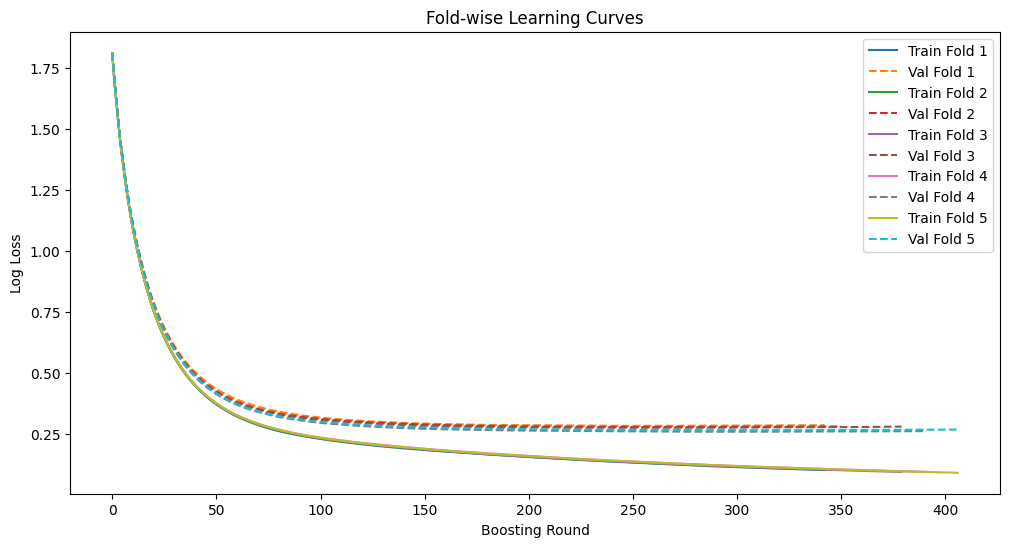

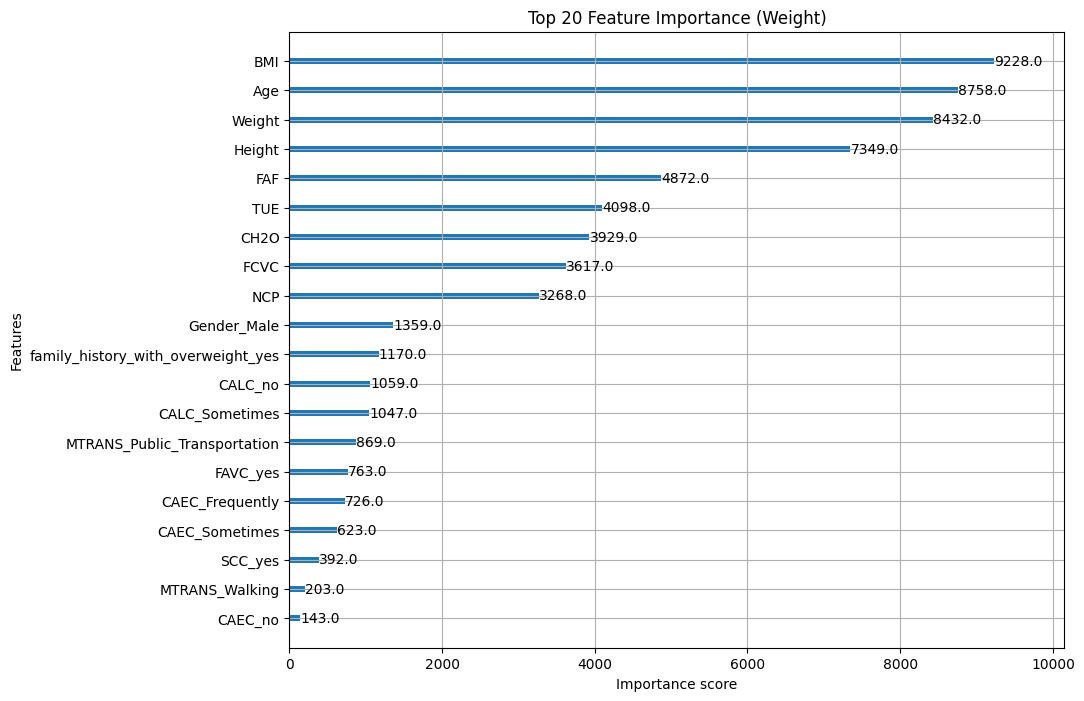

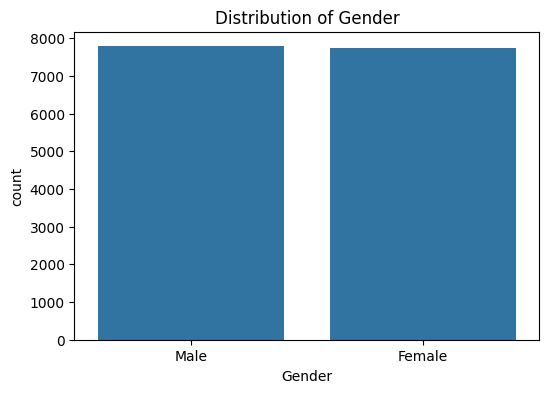

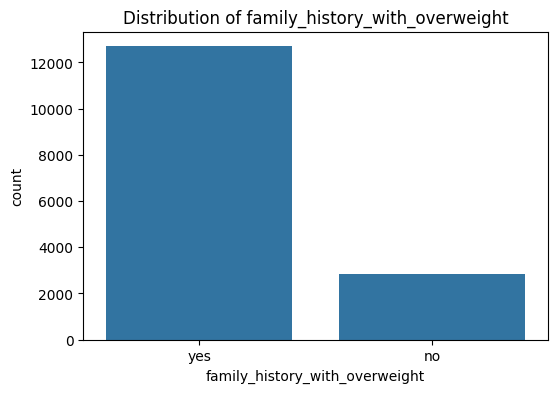

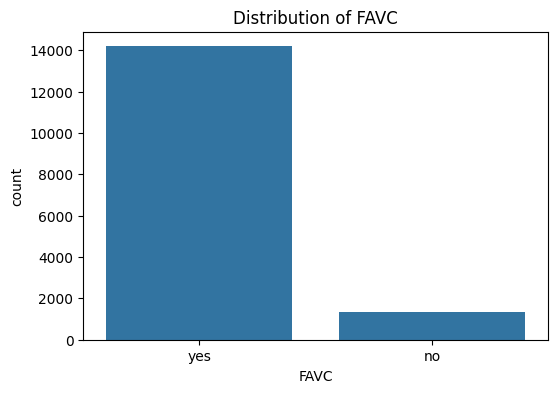

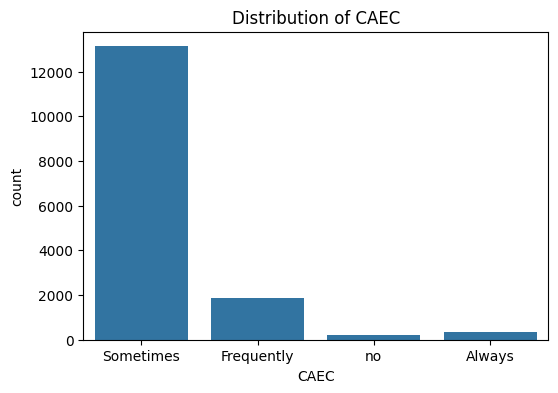

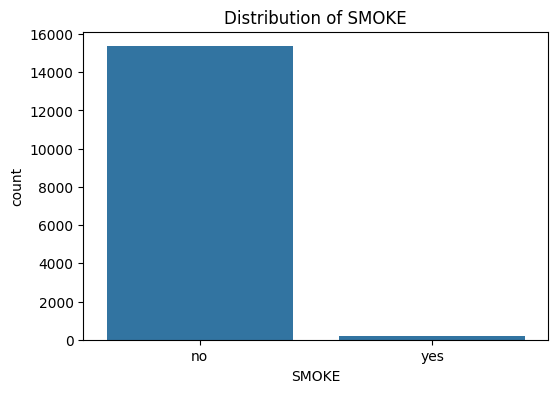

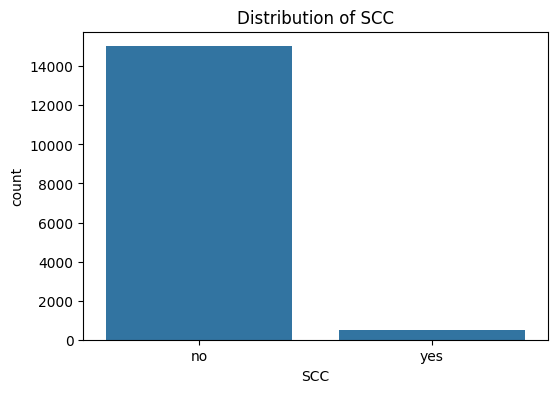

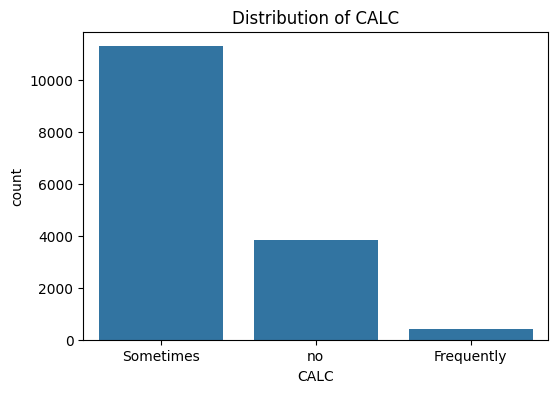

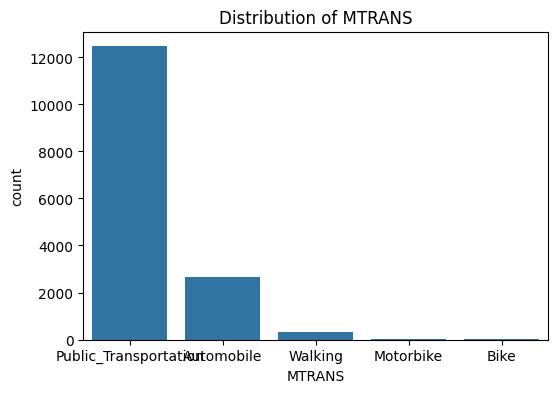

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score
import xgboost as xgb

# --- Load data ---
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")

# --- Feature Engineering ---
train_df['BMI'] = train_df['Weight'] / ((train_df['Height']/100.0)**2)
test_df['BMI'] = test_df['Weight'] / ((test_df['Height']/100.0)**2)

# --- Target ---
target = "WeightCategory"
le = LabelEncoder()
y = le.fit_transform(train_df[target])
X = train_df.drop(columns=['id', target], errors='ignore')
X_test = test_df.drop(columns=['id'], errors='ignore')
test_ids = test_df['id']

# --- One-hot encode categorical features ---
cat_cols = X.select_dtypes(include=['object']).columns.tolist()
X = pd.get_dummies(X, columns=cat_cols, drop_first=True)
X_test = pd.get_dummies(X_test, columns=cat_cols, drop_first=True)
X_test = X_test.reindex(columns=X.columns, fill_value=0)

# --- Scale numeric features ---
num_cols = ['Height', 'Weight', 'BMI']
scaler = StandardScaler()
X[num_cols] = scaler.fit_transform(X[num_cols])
X_test[num_cols] = scaler.transform(X_test[num_cols])

# --- CV setup ---
n_splits = 5
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=38)

# --- XGBoost parameters ---
xgb_params = {
    'objective': 'multi:softprob',
    'num_class': len(le.classes_),
    'learning_rate': 0.05,
    'max_depth': 6,
    'subsample': 0.9,
    'colsample_bytree': 0.9,
    'gamma': 0.1,
    'min_child_weight': 3,
    'tree_method': 'hist',
    'eval_metric': 'mlogloss',
    'seed': 38
}

# --- Train CV & average test predictions ---
test_preds_proba = np.zeros((X_test.shape[0], len(le.classes_)))
val_scores = []
fold_histories = []

for fold, (train_idx, val_idx) in enumerate(skf.split(X, y), 1):
    print(f"\n--- Fold {fold} ---")

    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y[train_idx], y[val_idx]

    dtrain = xgb.DMatrix(X_train, label=y_train)
    dval = xgb.DMatrix(X_val, label=y_val)
    dtest = xgb.DMatrix(X_test)

    evallist = [(dtrain, 'train'), (dval, 'eval')]
    evals_result = {}  # <-- dictionary to store metrics

    bst = xgb.train(
        params=xgb_params,
        dtrain=dtrain,
        num_boost_round=1800,
        evals=evallist,
        early_stopping_rounds=100,
        evals_result=evals_result,  # <-- pass here
        verbose_eval=200
    )

    fold_histories.append(evals_result)  # store for plotting

    y_val_pred = np.argmax(bst.predict(dval), axis=1)
    acc = accuracy_score(y_val, y_val_pred)
    f1 = f1_score(y_val, y_val_pred, average='macro')
    val_scores.append((acc, f1))
    print(f"Validation Accuracy: {acc:.4f}, F1-macro: {f1:.4f}")

    test_preds_proba += bst.predict(dtest) / n_splits

# --- CV Metrics ---
mean_acc = np.mean([s[0] for s in val_scores])
mean_f1 = np.mean([s[1] for s in val_scores])
print(f"\n✅ Mean CV Accuracy: {mean_acc:.4f}")
print(f"✅ Mean CV F1-macro: {mean_f1:.4f}")

# --- Final Predictions ---
final_pred_idx = np.argmax(test_preds_proba, axis=1)
final_pred_labels = le.inverse_transform(final_pred_idx)

# --- Submission ---
submission = pd.DataFrame({'id': test_ids, 'WeightCategory': final_pred_labels})
submission.to_csv("submission_xgb_seed38.csv", index=False)
print("\nSubmission saved as 'submission_xgb_seed38.csv'")

# ================= Visualization =================

# 1. Fold-wise learning curves
plt.figure(figsize=(12,6))
for i, history in enumerate(fold_histories, 1):
    plt.plot(history['train']['mlogloss'], label=f'Train Fold {i}')
    plt.plot(history['eval']['mlogloss'], '--', label=f'Val Fold {i}')
plt.xlabel('Boosting Round')
plt.ylabel('Log Loss')
plt.title('Fold-wise Learning Curves')
plt.legend()
plt.show()

# 2. Feature importance from last fold (XGBoost)
fig, ax = plt.subplots(figsize=(10,8))
xgb.plot_importance(bst, max_num_features=20, importance_type='weight', ax=ax)
plt.title('Top 20 Feature Importance (Weight)')
plt.show()

# 3. Countplot for categorical features
for col in cat_cols:
    plt.figure(figsize=(6,4))
    sns.countplot(x=train_df[col])
    plt.title(f'Distribution of {col}')
    plt.show()


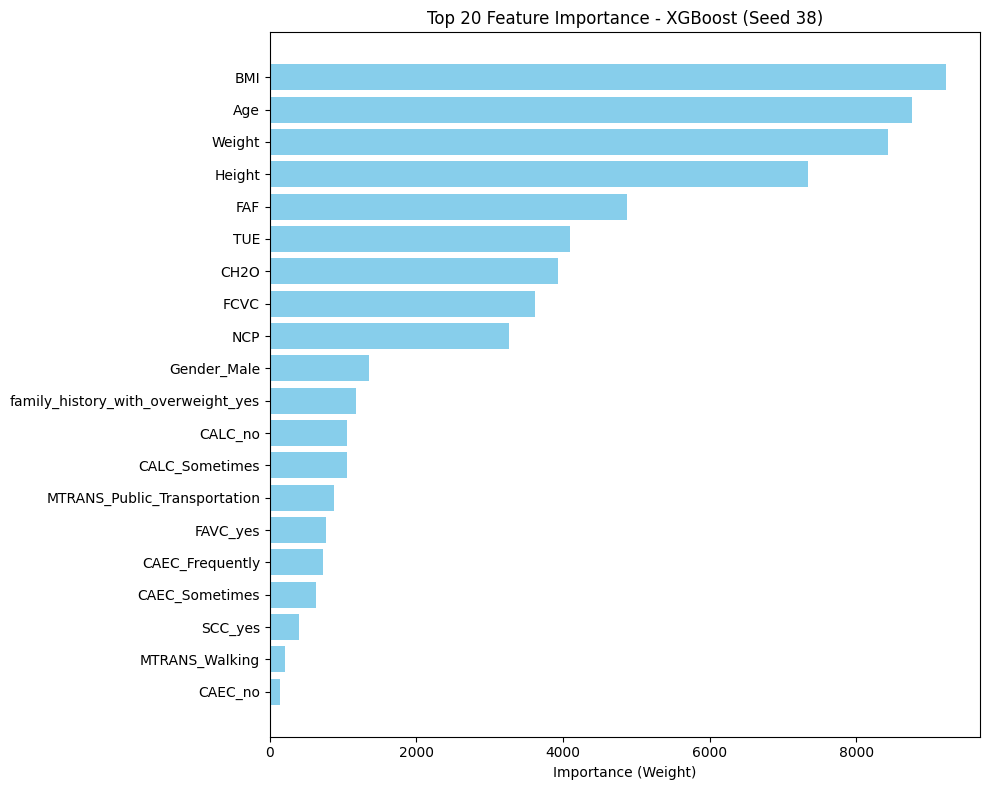

In [5]:
import matplotlib.pyplot as plt
import xgboost as xgb
import pandas as pd
import numpy as np

# Assuming 'bst' is your trained Booster from the last fold or final model
# And X contains the training features after preprocessing

# Get feature names (after one-hot encoding)
feature_names = X.columns

# Get feature importance (weight, gain, cover)
importance_dict = bst.get_score(importance_type='weight')  # you can also use 'gain' or 'cover'

# Convert to DataFrame for sorting
importance_df = pd.DataFrame({
    'Feature': list(importance_dict.keys()),
    'Importance': list(importance_dict.values())
})

# Sort descending
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Plot top 20 features
plt.figure(figsize=(10,8))
plt.barh(importance_df['Feature'][:20][::-1], importance_df['Importance'][:20][::-1], color='skyblue')
plt.xlabel("Importance (Weight)")
plt.title("Top 20 Feature Importance - XGBoost (Seed 38)")
plt.tight_layout()
plt.show()


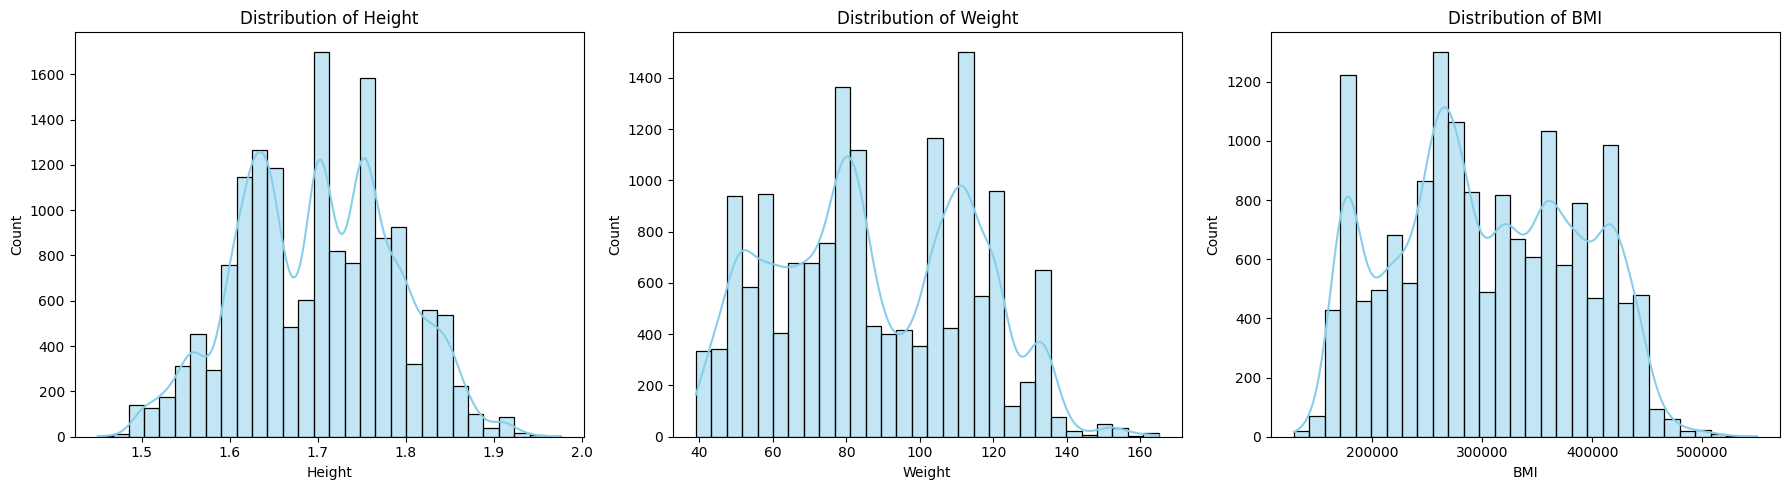

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

# Numeric columns
num_cols = ['Height', 'Weight', 'BMI']

plt.figure(figsize=(18,5))

for i, col in enumerate(num_cols, 1):
    plt.subplot(1, 3, i)
    sns.histplot(train_df[col], kde=True, bins=30, color='skyblue')
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Count')

plt.tight_layout()
plt.show()


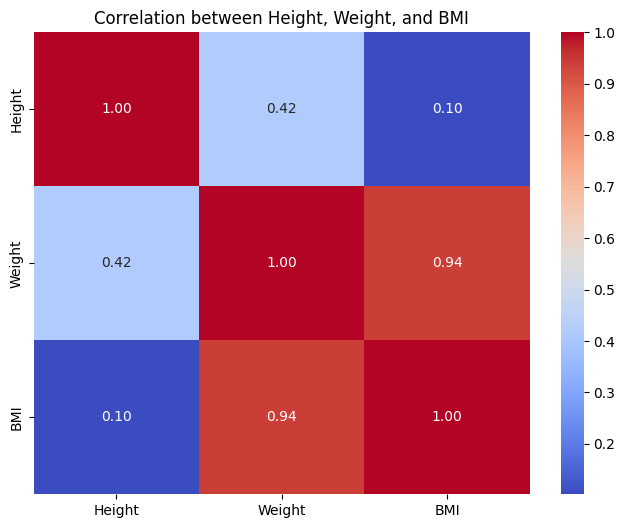

In [7]:
plt.figure(figsize=(8,6))
corr = train_df[num_cols].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation between Height, Weight, and BMI')
plt.show()

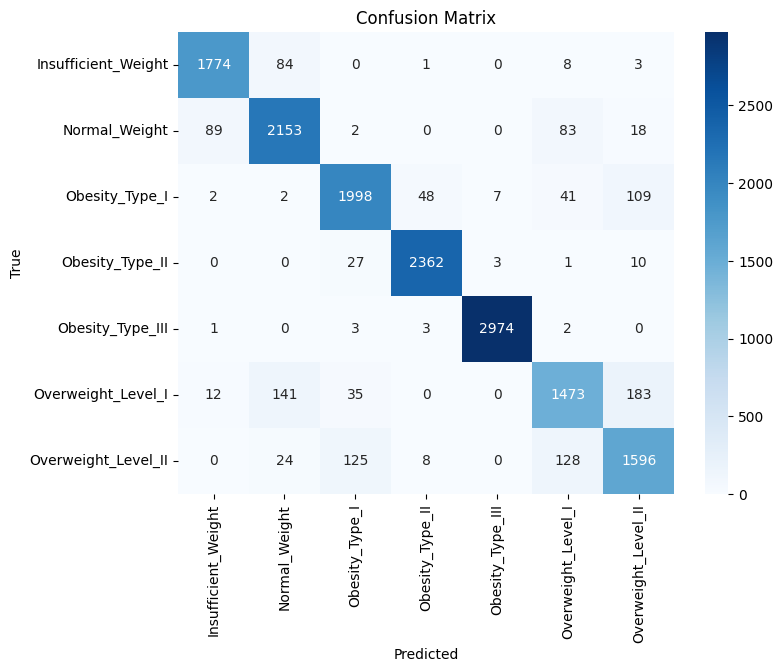

<Figure size 1000x800 with 0 Axes>

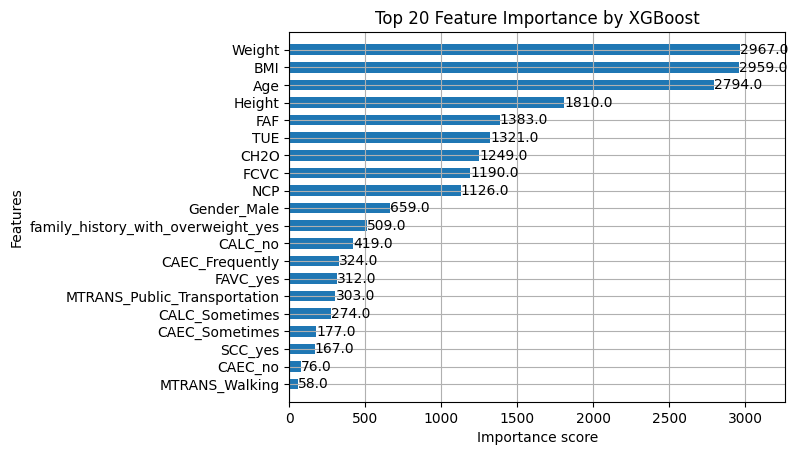

In [8]:
import xgboost as xgb
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Assuming X, y, le already defined

# 1️⃣ Fit classifier
clf = xgb.XGBClassifier(
    objective='multi:softprob',
    num_class=len(le.classes_),
    learning_rate=0.05,
    max_depth=6,
    subsample=0.9,
    colsample_bytree=0.9,
    gamma=0.1,
    min_child_weight=3,
    tree_method='hist',
    eval_metric='mlogloss',
    seed=38
)

clf.fit(X, y)

# 2️⃣ Confusion matrix
y_pred = clf.predict(X)
cm = confusion_matrix(y, y_pred)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# 3️⃣ Feature importance
plt.figure(figsize=(10,8))
xgb.plot_importance(clf, max_num_features=20, importance_type='weight', height=0.6)
plt.title('Top 20 Feature Importance by XGBoost')
plt.show()
